In [1]:
cd ..

/Users/kimyoungh/GoogleDrive/rich/main/rich


In [38]:
import numpy as np
import pandas as pd

import torch

import pyupbit

from models.picking_transformer2 import PickingTransformer2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
# Raw Data Loading
tickers = pyupbit.get_tickers(fiat='KRW')

count = 1032

close_data = {}
value_data = {}
for ticker in tickers:
    ohlcv = pyupbit.get_ohlcv(ticker=ticker, interval='day', count=count)

    if ohlcv is not None and len(ohlcv) == count:
        close_data[ticker] = ohlcv['close']
        value_data[ticker] = ohlcv['value']
close_data = pd.DataFrame(close_data)
value_data = pd.DataFrame(value_data)

returns = close_data.pct_change()
returns.iloc[0, :] = 0.

In [100]:
print(close_data.shape)
print(value_data.shape)

(1032, 71)
(1032, 71)


In [101]:
# Data Processing
window = 30
eps = 1e-6

indices = np.arange(close_data.shape[0])
indices = indices[window-1:-1]

In [102]:
indices

array([  29,   30,   31, ..., 1028, 1029, 1030])

In [103]:
np.save('train_data/picking_transformer/close_data.npy', close_data.values,
        allow_pickle=True)
np.save('train_data/picking_transformer/value_data.npy', value_data.values,
        allow_pickle=True)
np.save('train_data/picking_transformer/returns.npy', returns.values,
        allow_pickle=True)

In [104]:
from torch.utils.data import DataLoader
from datasets.picking_transformer2_dataset import PickingTransformer2Dataset

In [105]:
indices = np.arange(close_data.shape[0])
indices = indices[window-1:-1]
dataset = PickingTransformer2Dataset(
    close_data.values, value_data.values, returns.values,
    indices, window=30)

In [106]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [107]:
model = PickingTransformer2()
model.eval()
model.load_state_dict(
    torch.load('trained/picking_transformer2/picking_transformer2_best.pt',
    map_location='cpu'))

<All keys matched successfully>

In [108]:
len(dataloader)

1002

In [109]:
indices[0]

29

In [110]:
returns.values[indices[0]]

array([ 0.00097225,  0.02242437, -0.01147541,  0.01173021,  0.        ,
        0.02791878, -0.02586207, -0.03735632, -0.00403226, -0.01464435,
        0.01362398,  0.00371747,  0.        ,  0.00245098,  0.01284797,
        0.02597403,  0.02307692,  0.01169591,  0.00325733,  0.00818331,
        0.00429185,  0.0115304 ,  0.00275735,  0.00923077,  0.01112878,
        0.        , -0.00813008,  0.00530973,  0.07317073,  0.0170068 ,
       -0.00431034,  0.02366864,  0.00122764,  0.00823045,  0.00238095,
        0.        ,  0.01619433,  0.00769231, -0.00416667,  0.03125   ,
        0.00917431,  0.        ,  0.01183432,  0.01815981, -0.00913838,
        0.00220897, -0.05150215,  0.04956268, -0.03030303, -0.01388889,
       -0.01515152,  0.15277778, -0.00460829,  0.08421053,  0.0242915 ,
        0.0249584 ,  0.01170569,  0.01875   ,  0.16216216,  0.02717391,
       -0.00684932,  0.01724138,  0.        ,  0.03333333,  0.08474576,
        0.0093633 ,  0.03539823,  0.00719424,  0.01272727,  0.06

In [143]:
port_returns = []
weights_list = []
num = close_data.shape[1]
for i, (obs_dict, max_weights_dict, rets_dict) in enumerate(dataloader):
    obs = obs_dict[num]
    max_weights = max_weights_dict[num]
    rets = returns.values[indices[i] + 1]
    with torch.no_grad():
        weights, _ = model(obs, softmax=True)

    widx = weights.argmax()
    if widx == 0:
        pret = 0.
    else:
        pret = rets[widx - 1]

    port_returns.append(pret)
    weights_list.append(weights.numpy())
port_returns = pd.DataFrame(port_returns)
weights_list = pd.DataFrame(np.concatenate(weights_list, axis=0))

In [144]:
weights[0].argmax().item()

27

In [145]:
print(obs.shape)
print(obs)

torch.Size([1, 71, 3, 30])
tensor([[[[0.0000, 0.2217, 0.2124,  ..., 0.6966, 0.6816, 0.7344],
          [0.1822, 0.7261, 0.1003,  ..., 0.7124, 0.2055, 0.1198],
          [1.0000, 1.0000, 0.2630,  ..., 0.5507, 0.5450, 1.0000]],

         [[0.0000, 0.3398, 0.3689,  ..., 0.6165, 0.5227, 0.6133],
          [0.2630, 1.0000, 0.1609,  ..., 0.3744, 0.2594, 0.0000],
          [0.3963, 0.4636, 0.0966,  ..., 0.1183, 0.1996, 0.1698]],

         [[0.1232, 0.1957, 0.2264,  ..., 0.9312, 1.0000, 0.9348],
          [0.0162, 0.0923, 0.0323,  ..., 1.0000, 0.4739, 0.0251],
          [0.0263, 0.0287, 0.0093,  ..., 0.1708, 0.1790, 0.0415]],

         ...,

         [[0.0000, 0.1215, 0.1729,  ..., 0.7150, 0.7850, 0.7757],
          [0.0093, 0.0201, 0.0212,  ..., 0.0839, 0.0460, 0.0000],
          [0.0424, 0.0245, 0.0214,  ..., 0.0557, 0.0678, 0.0244]],

         [[0.0395, 0.1711, 0.2368,  ..., 0.7500, 0.7632, 0.7895],
          [0.0125, 0.0450, 0.4043,  ..., 0.1211, 0.0945, 0.0120],
          [0.0142, 0.0074,

In [146]:
weights_list

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.011345,0.005638,0.005003,0.046101,0.003415,0.003942,0.041005,0.149370,0.004530,0.002905,...,0.003788,0.003022,0.003050,0.019136,0.016885,0.034090,0.002959,0.005616,0.021711,0.004034
1,0.008475,0.004923,0.005812,0.003503,0.003023,0.003382,0.003052,0.140394,0.006011,0.003836,...,0.276150,0.002639,0.002205,0.032188,0.010340,0.007445,0.002417,0.002982,0.011977,0.002133
2,0.012490,0.007059,0.006712,0.004938,0.004861,0.005768,0.005618,0.070981,0.007390,0.004175,...,0.041623,0.004340,0.008057,0.094355,0.003963,0.010494,0.003465,0.003834,0.003771,0.003222
3,0.014395,0.008482,0.006184,0.004738,0.005299,0.004526,0.004269,0.068526,0.005106,0.003936,...,0.058196,0.006753,0.004448,0.073906,0.004389,0.005862,0.004860,0.014361,0.004794,0.004188
4,0.009658,0.005498,0.010157,0.004890,0.012658,0.005296,0.006526,0.028335,0.004997,0.009814,...,0.027980,0.005773,0.005808,0.035818,0.009166,0.009587,0.016999,0.019914,0.017031,0.003774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0.011810,0.010122,0.009794,0.009693,0.015434,0.005944,0.012563,0.019297,0.013285,0.005297,...,0.014925,0.013573,0.007936,0.046990,0.010061,0.013076,0.012895,0.005264,0.006137,0.005037
998,0.006494,0.003671,0.004214,0.017890,0.005677,0.002926,0.002883,0.004674,0.003644,0.004716,...,0.010766,0.007542,0.010036,0.012707,0.009957,0.014579,0.010346,0.015395,0.014126,0.003682
999,0.003722,0.002549,0.002077,0.004423,0.001404,0.001302,0.001460,0.001684,0.001685,0.007622,...,0.000810,0.001418,0.001156,0.003595,0.002108,0.000905,0.001406,0.001400,0.001376,0.000959
1000,0.019410,0.013121,0.009513,0.036765,0.020362,0.008800,0.008927,0.027798,0.010267,0.006330,...,0.007906,0.005738,0.004071,0.003777,0.004678,0.004289,0.004101,0.005422,0.009308,0.023233


In [147]:
torch.FloatTensor([0.])

tensor([0.])

In [148]:
weights

tensor([[0.0219, 0.0113, 0.0080, 0.0451, 0.0078, 0.0065, 0.0060, 0.0088, 0.0109,
         0.0053, 0.0056, 0.0063, 0.0066, 0.0054, 0.0050, 0.0046, 0.0044, 0.0050,
         0.0048, 0.0532, 0.0051, 0.0057, 0.0043, 0.0042, 0.0041, 0.0048, 0.0058,
         0.2213, 0.0044, 0.0046, 0.0047, 0.0043, 0.0049, 0.0048, 0.0077, 0.0049,
         0.0052, 0.0049, 0.0053, 0.0044, 0.0047, 0.0047, 0.1001, 0.0050, 0.0144,
         0.0059, 0.0042, 0.0051, 0.0046, 0.0063, 0.0055, 0.0625, 0.0058, 0.0062,
         0.0400, 0.0050, 0.0048, 0.0057, 0.0232, 0.0055, 0.0151, 0.0633, 0.0054,
         0.0048, 0.0061, 0.0073, 0.0052, 0.0052, 0.0050, 0.0056, 0.0042, 0.0058]])

In [149]:
weights.max()

tensor(0.2213)

In [150]:
close_data.columns[0]

'KRW-BTC'

In [151]:
port_returns

,0
0,0.244131
1,0.978082
2,-0.008086
3,0.281369
4,-0.005525
...,...
997,0.012658
998,0.442671
999,0.139009
1000,0.159274


In [152]:
port_returns.describe()

,0
count,1002.000000
mean,0.061580
std,0.258805
min,-0.484642
25%,-0.027714
50%,0.017712
75%,0.093496
max,5.878788


<AxesSubplot:>

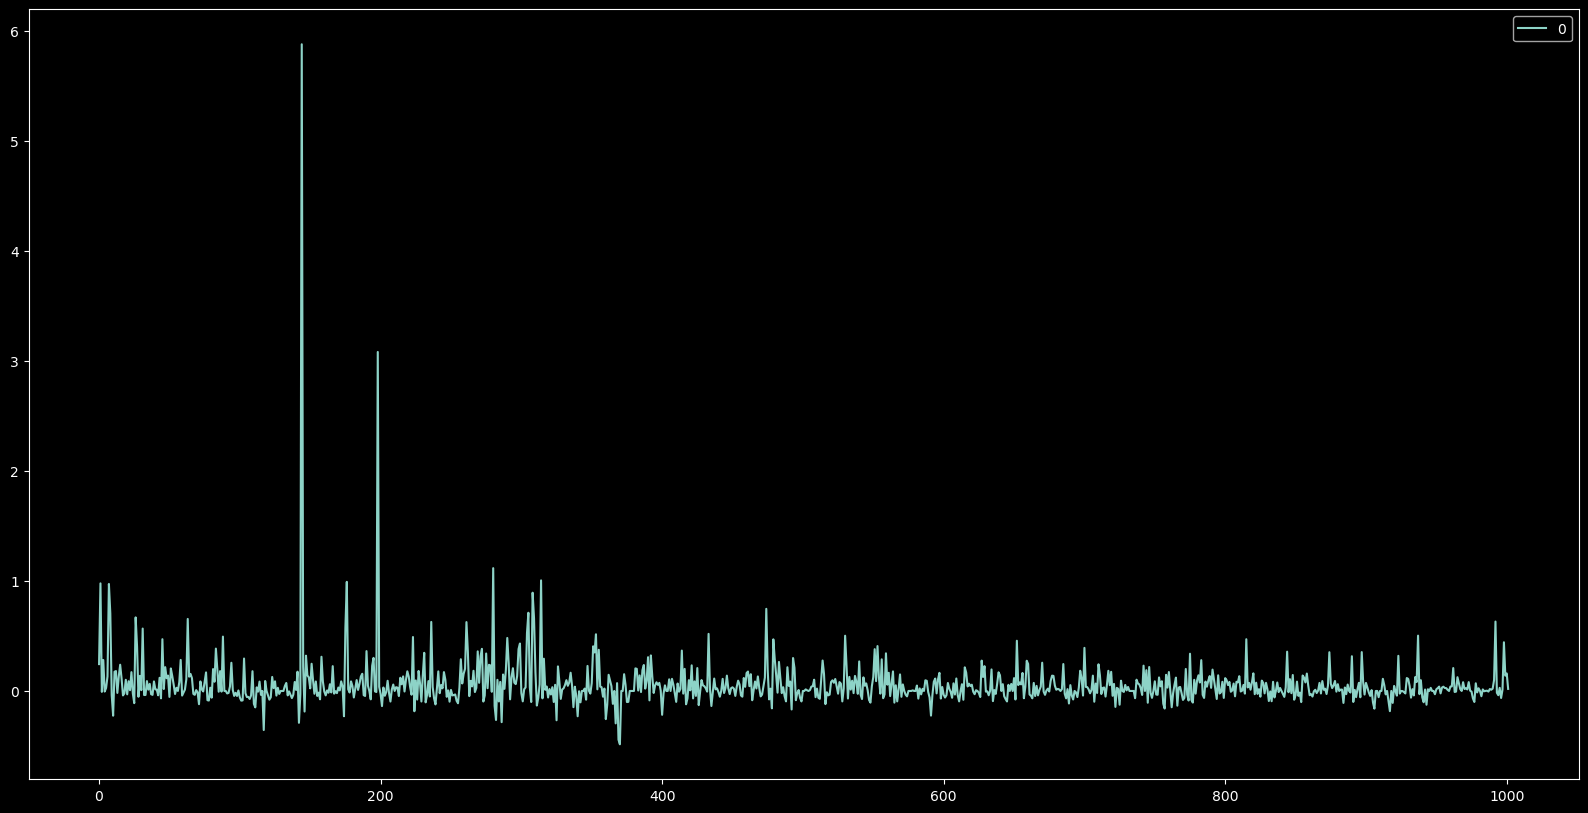

In [153]:
port_returns.plot(figsize=(20, 10))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

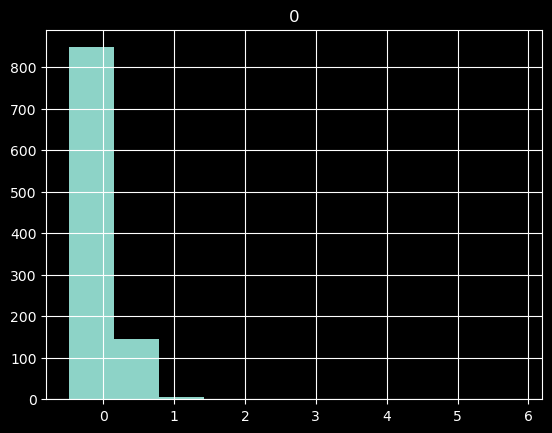

In [154]:
port_returns.hist()

<AxesSubplot:>

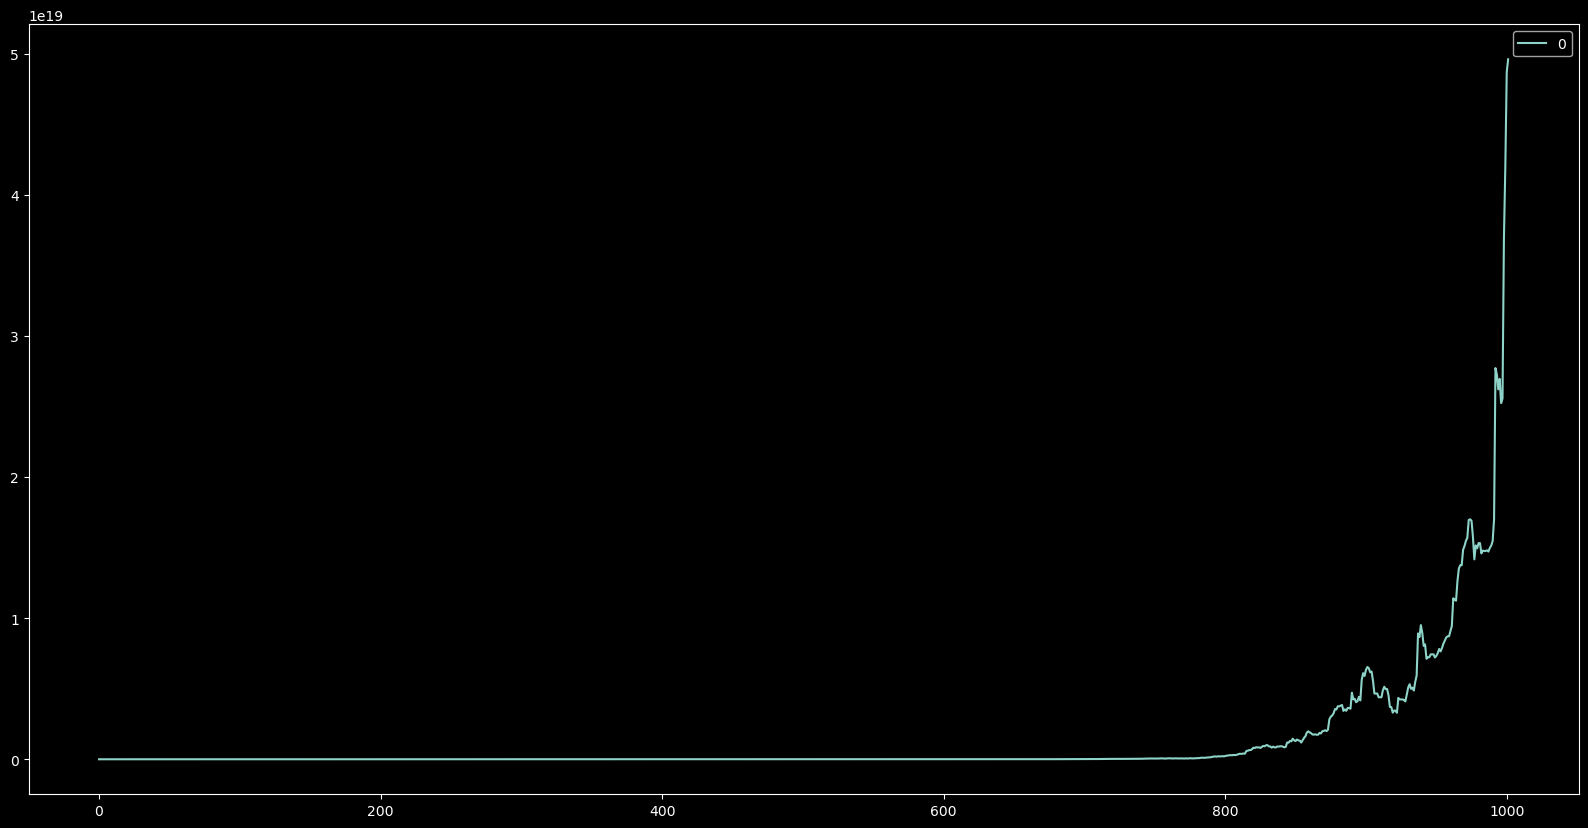

In [155]:
((1 + port_returns).cumprod() - 1).plot(figsize=(20, 10))

In [156]:
np.random.randint(5, 20)

15

In [157]:
arr = np.random.randn(20, 20)

In [158]:
(1 + port_returns).cumprod() - 1

,0
0,2.441315e-01
1,1.460994e+00
2,1.441094e+00
3,2.127942e+00
4,2.110660e+00
...,...
997,2.556450e+19
998,3.688116e+19
999,4.200795e+19
1000,4.869874e+19


In [159]:
port_returns.tail(20)

,0
982,-0.047817
983,0.014045
984,-0.002469
985,0.000691
986,0.002725
987,-0.005714
988,0.017647
989,0.011299
990,0.020797
991,0.099109


In [128]:
from trading.upbit_trader import UpbitTrader

In [65]:
ut = UpbitTrader()

In [34]:
ut.upbit.get_chance('KRW-BTC')

{'bid_fee': '0.0005',
 'ask_fee': '0.0005',
 'maker_bid_fee': '0.0005',
 'maker_ask_fee': '0.0005',
 'market': {'id': 'KRW-BTC',
  'name': 'BTC/KRW',
  'order_types': ['limit'],
  'order_sides': ['ask', 'bid'],
  'bid_types': ['limit', 'price'],
  'ask_types': ['limit', 'market'],
  'bid': {'currency': 'KRW', 'min_total': '5000'},
  'ask': {'currency': 'BTC', 'min_total': '5000'},
  'max_total': '1000000000',
  'state': 'active'},
 'bid_account': {'currency': 'KRW',
  'balance': '0.10351466',
  'locked': '0',
  'avg_buy_price': '0',
  'avg_buy_price_modified': True,
  'unit_currency': 'KRW'},
 'ask_account': {'currency': 'BTC',
  'balance': '0',
  'locked': '0',
  'avg_buy_price': '44512302.8151',
  'avg_buy_price_modified': False,
  'unit_currency': 'KRW'}}

In [41]:
ut.upbit.get_balance('KRW-XRP')

0

In [160]:
a = None

In [161]:
if a != 1:
    print(a)

None
